In [95]:
import sys
import os 
sys.path.append('..')  #adds the Root Directory to the system path
from BL_CalciumAnalysis.image_analysis_methods import ImageAnalysis

In [96]:
from PIL import Image
import numpy as np

In [97]:
print(sys.executable) #print the path of the Python executable being used, which should point to the Python interpreter in your Conda environment.

/opt/anaconda3/envs/biolumi_calcium_imaging/bin/python


In [98]:
project_folder = '/Volumes/MannySSD/cablam_imaging/raw_data_for_analysis' #path to the folder containing the raw data to be analyzed (i.e. the folder containing the folders for each experiment)
analysis = ImageAnalysis(project_folder)

print(analysis.directory_df)
analysis.directory_df

                                   directory_name  \
0                  g21_12072023_estim_10hz_na_blk   
1                  g22_12072023_estim_10hz_na_blk   
2                  g23_12072023_estim_10hz_na_blk   
3                c33_12092023_estim_10hz_1xfz_blk   
4              c33_12092023_estim_10hz_1xfz_blk_1   
5                c32_12092023_estim_10hz_1xfz_blk   
6                c31_12092023_estim_10hz_1xfz_blk   
7                  g11_12092023_estim_10hz_na_blk   
8        c12_10072023_estim_10hz_1xfz_blk_biolumi   
9        c13_10072023_estim_10hz_1xfz_blk_biolumi   
10  c11_12232023_estim_10hz_1xfz_biolumi_combined   

                                       directory_path  
0   /Volumes/MannySSD/cablam_imaging/raw_data_for_...  
1   /Volumes/MannySSD/cablam_imaging/raw_data_for_...  
2   /Volumes/MannySSD/cablam_imaging/raw_data_for_...  
3   /Volumes/MannySSD/cablam_imaging/raw_data_for_...  
4   /Volumes/MannySSD/cablam_imaging/raw_data_for_...  
5   /Volumes/MannySSD/cabla

,directory_name,directory_path
0,g21_12072023_estim_10hz_na_blk,/Volumes/MannySSD/cablam_imaging/raw_data_for_...
1,g22_12072023_estim_10hz_na_blk,/Volumes/MannySSD/cablam_imaging/raw_data_for_...
2,g23_12072023_estim_10hz_na_blk,/Volumes/MannySSD/cablam_imaging/raw_data_for_...
3,c33_12092023_estim_10hz_1xfz_blk,/Volumes/MannySSD/cablam_imaging/raw_data_for_...
4,c33_12092023_estim_10hz_1xfz_blk_1,/Volumes/MannySSD/cablam_imaging/raw_data_for_...
5,c32_12092023_estim_10hz_1xfz_blk,/Volumes/MannySSD/cablam_imaging/raw_data_for_...
6,c31_12092023_estim_10hz_1xfz_blk,/Volumes/MannySSD/cablam_imaging/raw_data_for_...
7,g11_12092023_estim_10hz_na_blk,/Volumes/MannySSD/cablam_imaging/raw_data_for_...
8,c12_10072023_estim_10hz_1xfz_blk_biolumi,/Volumes/MannySSD/cablam_imaging/raw_data_for_...
9,c13_10072023_estim_10hz_1xfz_blk_biolumi,/Volumes/MannySSD/cablam_imaging/raw_data_for_...


In [99]:
# Since the folders are directly inside the project_folder, you don't need to append any subdirectory name
data_files = analysis.list_files('') 
print(data_files) #print the list of files in the project folder 

directories = analysis.list_directories()
print(directories) #print the list of directories in the project folder

['/Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/c11_10072023_estim_10hz_1xfz_biolumi.tif', '/Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/c31_12092023_estim_10hz_1xfz_blk_biolumi_combined_compensated_image.tif', '/Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/c12_10072023_estim_10hz_1xfz_biolumi.tif', '/Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/._c31_12092023_estim_10hz_1xfz_blk_biolumi_combined_compensated_image.tif', '/Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/c13_10072023_estim_10hz_1xfz_biolumi.tif', '/Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/g21_12072023_estim_10hz_na_blk/g21_12072023_estim_10hz_na_blk_fluor_combined.tif', '/Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/g21_12072023_estim_10hz_na_blk/g21_12072023_estim_10hz_na_blk_fluor.csv', '/Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/g21_12072023_estim_10hz_na_blk/._g21_12072023_estim_10hz_na_blk_fluor.csv', '/Volumes/MannySSD/cablam_imaging/raw_d

In [100]:
# Assuming analysis is an instance of ImageAnalysis
first_row = analysis.directory_df.iloc[3]
directory_path = first_row['directory_path']

# Automatically generate file paths based on the directory path
dark_frames_path = os.path.join(directory_path, "dark_frames.tiff")
raw_image_path = os.path.join(directory_path, "raw_image.tiff")

print("dark_frames_path:", dark_frames_path)
print("raw_image_path:", raw_image_path)

tiff_path = '/Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/c11_12232023_estim_10hz_1xfz_biolumi_combined/c11_12232023_estim_10hz_1xfz_biolumi_combined.tif'

# Generate the dark image
dark_image = analysis.generate_dark_image(tiff_path) #generates a dark image from the first 200 frames of the tiff file 

dark_frames_path: /Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/c33_12092023_estim_10hz_1xfz_blk/dark_frames.tiff
raw_image_path: /Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/c33_12092023_estim_10hz_1xfz_blk/raw_image.tiff


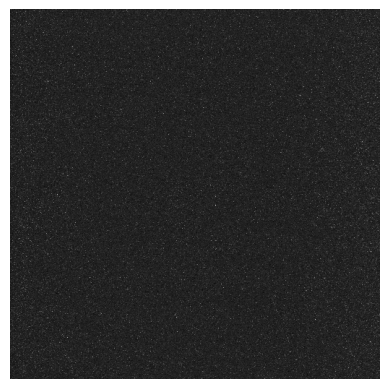

In [101]:
import matplotlib.pyplot as plt
# Display the dark image
plt.imshow(dark_image, cmap='gray')
plt.axis('off')
plt.show()


(2134, 2134)
(512, 512)
[177 255]


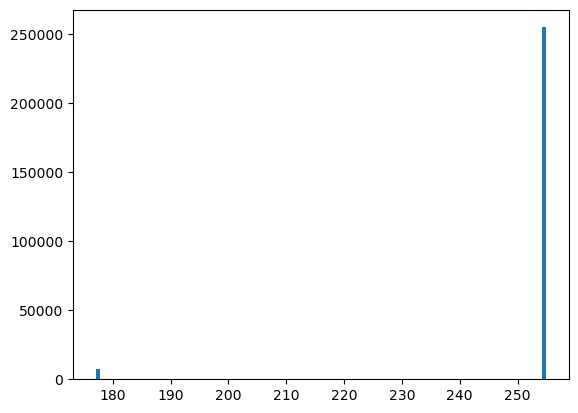

In [102]:
import numpy as np
#import the tiff file from the path

mask_tiff_path = '/Volumes/MannySSD/cablam_imaging/raw_data_for_analysis/c11_12232023_estim_10hz_1xfz_biolumi_combined/c11_12232023_estim_10hz_1xfz_biolumi_combined_max_projection_labels_1.tif'

# Load the mask tiff file with PIL
mask_image = Image.open(mask_tiff_path)
print(mask_image.size) #print the size of the mask image

resized_mask_image = mask_image.resize((512, 512), Image.NEAREST) #resize the mask image to the same size as the raw image, Image.NEAREST is used to avoid interpolation
print(resized_mask_image.size) #print the size of the resized mask image

#describe the pixel values of the mask image to see the unique values
print(np.unique(np.array(resized_mask_image))) #print the unique pixel values of the mask image 

#display the distrubition of the pixel values of the mask image
plt.hist(np.array(resized_mask_image).flatten(), bins=100)
plt.show() 


In [103]:
print(type(resized_mask_image))

<class 'PIL.Image.Image'>


Number of unique ROIs: 46


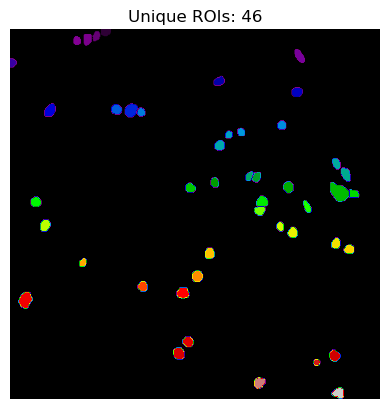

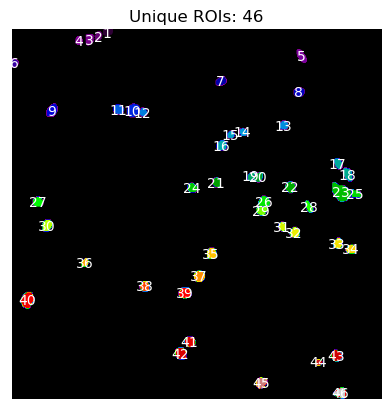

In [104]:
!pip install scikit-image

import numpy as np
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt


# Assuming 'mask_image' is your PIL Image object
# Convert the PIL image to a NumPy array
image_array = np.array(resized_mask_image)

# Convert the image to a binary mask: 177 for ROIs and 255 for the background
# We will set ROIs to 1 and the background to 0
binary_mask = np.where(image_array == 177, 1, 0)

# Use skimage's label function to label different ROIs
# The connectivity parameter is set to 1 for labeling connected components considering 4-connectivity
labeled_image = label(binary_mask, connectivity=1)

# The number of unique ROIs excluding the background (0 label)
num_rois = np.max(labeled_image)

print(f"Number of unique ROIs: {num_rois}")

# Visualize the labeled ROIs, each color represents a different ROI
plt.imshow(labeled_image, cmap='nipy_spectral')
plt.axis('off')
plt.title(f"Unique ROIs: {num_rois}")
plt.show()





# Use regionprops to get properties of labeled regions
regions = regionprops(labeled_image)

plt.imshow(labeled_image, cmap='nipy_spectral')
plt.axis('off')
plt.title(f"Unique ROIs: {num_rois}")

# Annotate each ROI with its corresponding label (ID)
for region in regions:
    # Get the coordinates of the centroid of the region
    y, x = region.centroid
    # Annotate the ROI ID at the centroid position
    plt.text(x, y, str(region.label), color='white', ha='center', va='center')

plt.show()


In [105]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

# Assuming 'labeled_image' is your mask with ROIs labeled
# Load the time series .tiff file
time_series = io.imread(tiff_path)  # A 3D numpy array: time x height x width

# Determine the number of ROIs and frames
num_rois = np.max(labeled_image)
num_frames = time_series.shape[0]

# Initialize an array to store calcium signal data for each ROI over time
calcium_signals = np.zeros((num_rois, num_frames))

# Extract the signal from each ROI in each frame
for t in range(num_frames):
    frame = time_series[t]
    
    for roi in range(1, num_rois + 1):  # ROI labels start from 1 as 0 is background
        roi_mask = labeled_image == roi
        roi_data = frame[roi_mask]
        calcium_signals[roi - 1, t] = np.mean(roi_data)  # Mean intensity for ROI

# `calcium_signals` now holds the mean intensity for each ROI at each time point




In [106]:
#export the calcium signals to a csv file with the ROI labels as the column names and the frame numbers as a column 
import pandas as pd

# Create a DataFrame from the calcium signals
calcium_df = pd.DataFrame(calcium_signals.T, columns=[f"ROI_{i}" for i in range(1, num_rois + 1)])

# Add a column for the frame number
calcium_df['Frame'] = np.arange(1, num_frames + 1)

# Save the DataFrame to a CSV file in the same directory as the raw data file with matching name
csv_path = tiff_path.replace(".tif", "_calcium_signals.csv")
calcium_df.to_csv(csv_path, index=False)


In [107]:
calcium_df

,ROI_1,ROI_2,ROI_3,ROI_4,ROI_5,ROI_6,ROI_7,ROI_8,ROI_9,ROI_10,...,ROI_38,ROI_39,ROI_40,ROI_41,ROI_42,ROI_43,ROI_44,ROI_45,ROI_46,Frame
0,508.024390,508.478261,509.318182,507.198020,508.875000,504.703297,507.081633,506.902439,509.334951,508.348837,...,507.553333,508.635071,510.695793,508.307229,508.359223,507.513966,506.835821,508.071429,509.404255,1
1,510.227642,511.478261,510.564935,510.643564,507.589286,510.956044,507.632653,508.591463,509.461165,509.554264,...,509.140000,508.251185,508.634304,507.530120,507.922330,510.642458,510.761194,508.604396,510.361702,2
2,509.560976,510.721739,509.545455,505.742574,509.803571,508.219780,509.530612,510.085366,507.980583,506.829457,...,508.866667,508.729858,509.255663,509.361446,508.150485,510.418994,507.477612,508.703297,509.808511,3
3,508.951220,507.191304,509.603896,509.297030,507.363095,508.571429,507.591837,508.817073,509.402913,508.608527,...,508.946667,509.753555,508.569579,510.114458,509.111650,510.016760,508.477612,508.214286,511.819149,4
4,509.747967,507.982609,508.344156,507.871287,508.386905,509.032967,509.707483,509.237805,510.752427,508.267442,...,506.740000,507.981043,508.640777,509.518072,508.121359,510.843575,508.179104,508.280220,508.648936,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6027,525.739837,520.626087,516.123377,514.118812,514.571429,512.054945,514.285714,518.743902,515.339806,518.147287,...,521.013333,518.450237,519.666667,518.144578,520.990291,545.094972,526.238806,511.604396,519.872340,6028
6028,522.243902,515.086957,515.720779,510.693069,514.446429,514.736264,513.517007,517.713415,516.810680,521.635659,...,520.140000,521.232227,519.864078,519.084337,523.276699,536.424581,523.164179,512.972527,514.005319,6029
6029,528.707317,517.478261,515.850649,516.059406,515.392857,512.142857,515.129252,518.286585,518.728155,518.348837,...,520.433333,522.109005,521.501618,523.807229,524.689320,539.882682,517.417910,513.038462,520.324468,6030
6030,527.130081,520.104348,517.610390,515.000000,517.434524,513.197802,518.891156,516.054878,513.048544,519.186047,...,525.326667,518.336493,520.051780,517.066265,518.135922,539.195531,528.313433,510.989011,514.702128,6031


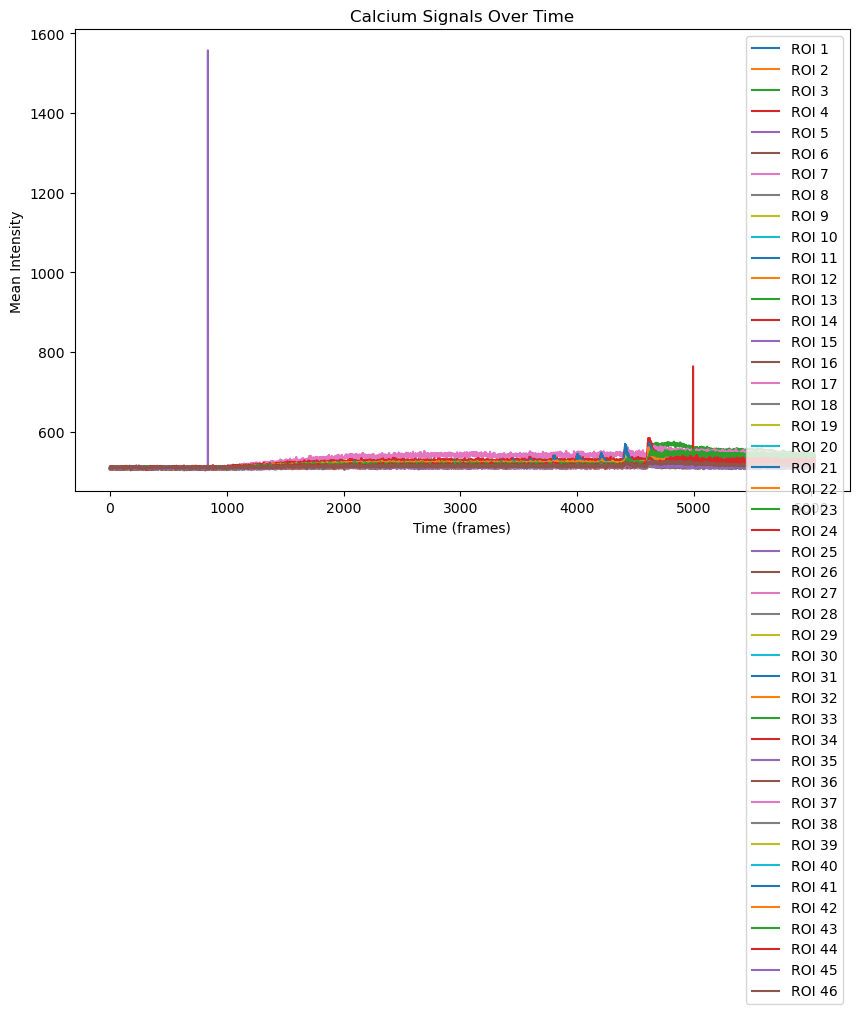

In [108]:
# Plot the calcium signals
plt.figure(figsize=(10, 6))
for roi in range(num_rois):
    plt.plot(calcium_signals[roi], label=f'ROI {roi + 1}')

plt.xlabel('Time (frames)')
plt.ylabel('Mean Intensity')
plt.title('Calcium Signals Over Time')
plt.legend()
plt.show()


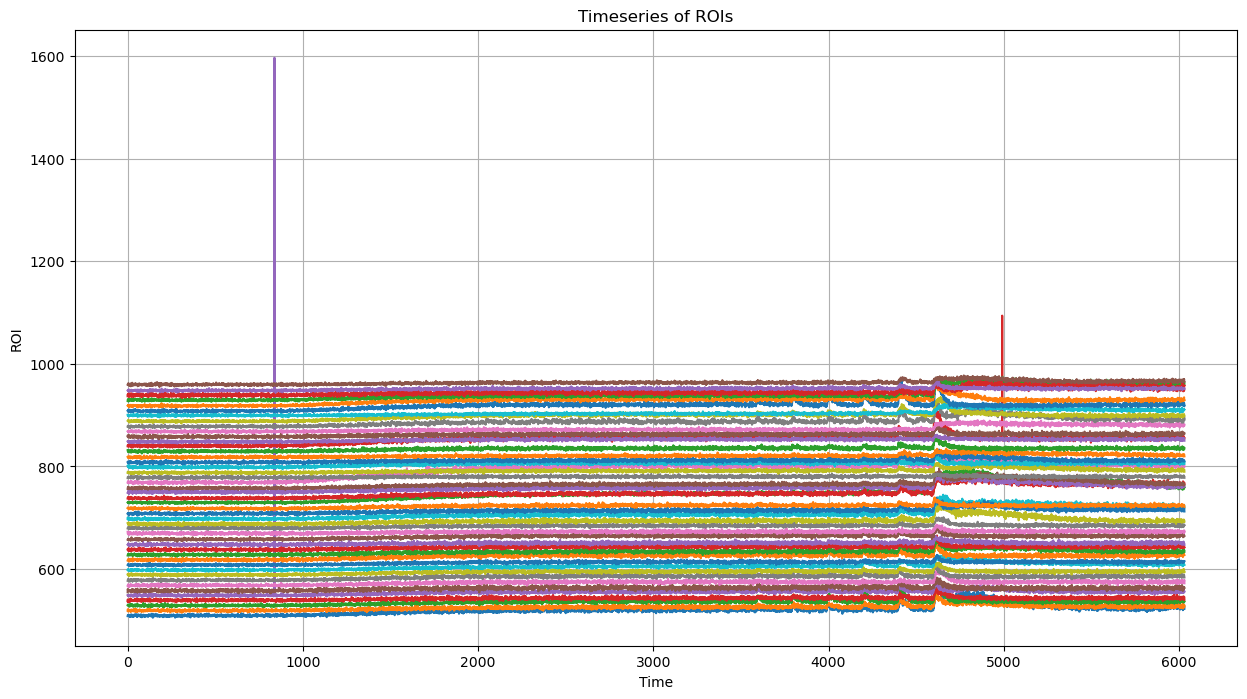

In [109]:

# Assuming 'tiff_path' contains the path to your time series TIFF file
# and 'labeled_image' is your ROI mask loaded as a numpy array
time_series = io.imread(tiff_path)  # This should be a 3D numpy array (time, y, x)
num_rois = np.max(labeled_image)
num_frames = time_series.shape[0]

# Initialize an array to hold the calcium signal data
calcium_signals = np.zeros((num_rois, num_frames))

# Process each frame to extract ROI signals
for t in range(num_frames):
    frame = time_series[t]
    for roi in range(1, num_rois + 1):  # ROIs are labeled from 1 to num_rois
        roi_mask = labeled_image == roi
        roi_data = frame[roi_mask]
        calcium_signals[roi - 1, t] = np.mean(roi_data) if roi_data.size > 0 else 0

# Plotting the calcium signals
offset = 10  # Change this value to adjust the vertical spacing between ROIs
plt.figure(figsize=(15, 8))
for roi in range(num_rois):
    plt.plot(calcium_signals[roi] + offset * roi, label=f'ROI {roi + 1}')  # Offset each ROI signal

plt.xlabel('Time')
plt.ylabel('ROI')
plt.title('Timeseries of ROIs')
#plt.yticks(ticks=np.arange(num_rois) * offset, labels=np.arange(1, num_rois + 1))  # Set y-ticks to show ROI IDs
plt.grid(True)
plt.show()


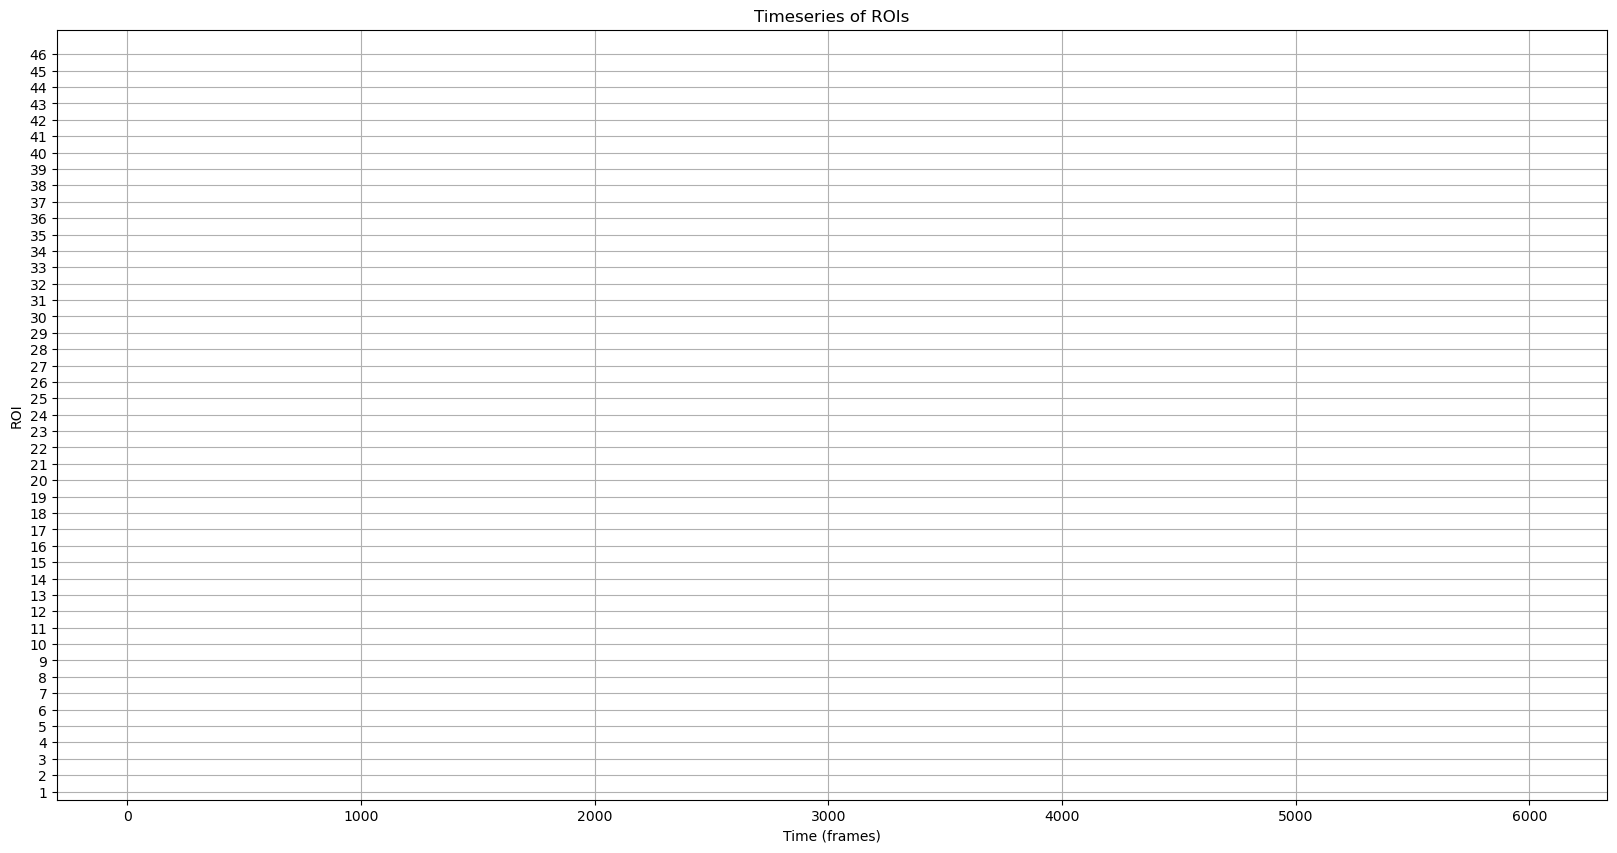

In [110]:
# Load the time series TIFF file from the given path
time_series = io.imread(tiff_path)  # 3D numpy array: (time, y, x)
num_rois = np.max(labeled_image)    # Assuming labeled_image is already defined as shown before
num_frames = time_series.shape[0]

# Initialize an array to hold the calcium signal data for each ROI over time
calcium_signals = np.zeros((num_rois, num_frames))

# Process each frame to extract ROI signals
for t in range(num_frames):
    frame = time_series[t]
    for roi in range(1, num_rois + 1):  # ROI labels start from 1
        roi_mask = labeled_image == roi
        roi_data = frame[roi_mask]
        calcium_signals[roi - 1, t] = np.mean(roi_data) if np.any(roi_mask) else np.nan

# Plotting the calcium signals
plt.figure(figsize=(20, 10))  # Adjust the figure size as necessary

# Define vertical offset between lines to ensure clear separation
vertical_offset = 10  # Change as needed to match the plot scale and ROI separation

# Iterate over the ROIs to plot each one with an offset
for roi_idx in range(num_rois):
    plt.plot(calcium_signals[roi_idx] + (vertical_offset * roi_idx), label=f'ROI {roi_idx + 1}')

# Set the y-ticks to correspond to the ROIs
# Here, we create a list of y-tick positions based on the number of ROIs and the vertical offset
plt.yticks(ticks=np.arange(num_rois) * vertical_offset, labels=np.arange(1, num_rois + 1))

plt.xlabel('Time (frames)')
plt.ylabel('ROI')
plt.title('Timeseries of ROIs')
plt.grid(True)  # Include grid for better readability

# Optional: Adjust the limits of the y-axis if needed to fit your data range
plt.ylim(-5, (num_rois - 1) * vertical_offset + 15)

# Optional: If you want to show a legend mapping colors to ROI IDs
# plt.legend(loc='upper right')

plt.show()


In [111]:
def max_projection_mean_values(tiff_path):
    """
    Generates a maximum intensity projection based on the mean values of a multi-frame TIFF file.

    Parameters:
    tiff_path (str): Path to the multi-frame TIFF file.

    Returns:
    numpy.ndarray: An array representing the maximum intensity projection of the mean values.
    """
    with Image.open(tiff_path) as img:
        # Initialize a summing array with the shape of the first frame and float type for mean calculation
        sum_image = np.zeros((img.height, img.width), dtype=np.float32)

        # Sum up all frames
        for i in range(img.n_frames):
            img.seek(i)
            sum_image += np.array(img, dtype=np.float32)

        # Compute the mean image by dividing the sum by the number of frames
        mean_image = sum_image / img.n_frames

        # Return the maximum projection of the mean values
        # In this context, since it's already the mean image, the max projection would be the image itself
        # If you need a max projection across z-stacks or different channels, additional modifications are needed
        return mean_image

# Usage example
# Replace 'path_to_tiff' with the path to your TIFF file
max_proj_image = max_projection_mean_values(tiff_path)


In [112]:
def sum_projection_images(tiff_path):
    """
    Generates a summed projection based on the sum of all frames of a multi-frame TIFF file.

    Parameters:
    tiff_path (str): Path to the multi-frame TIFF file.

    Returns:
    numpy.ndarray: An array representing the summed projection of all frames.
    """
    with Image.open(tiff_path) as img:
        # Initialize a summing array with the shape of the first frame and float type for sum calculation
        sum_image = np.zeros((img.height, img.width), dtype=np.float32)

        # Sum up all frames
        for i in range(img.n_frames):
            img.seek(i)
            sum_image += np.array(img, dtype=np.float32)

        return sum_image

# Usage example
# Replace 'path_to_tiff' with the path to your TIFF file
sum_proj_image = sum_projection_images(tiff_path)


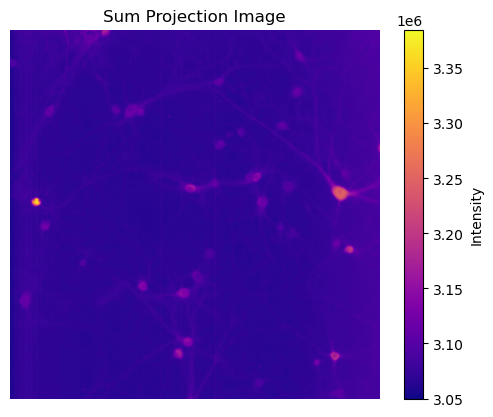

In [113]:
# Display the max projection image
plt.imshow(sum_proj_image, cmap='plasma')
#add a colorbar to the image and display it and title to the image
plt.colorbar(label='Intensity')
plt.title('Sum Projection Image')
plt.axis('off')
plt.show()

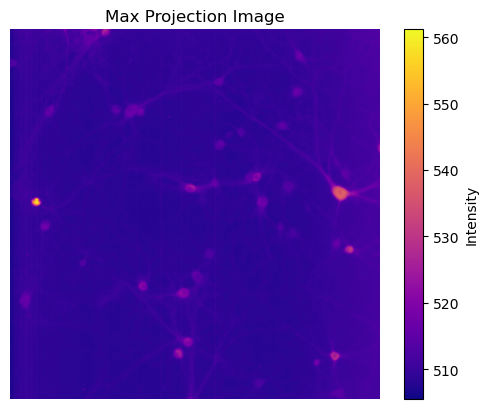

In [114]:
import matplotlib.pyplot as plt

# Display the max projection image
plt.imshow(max_proj_image, cmap='plasma')
plt.colorbar(label='Intensity')
plt.title('Max Projection Image')
plt.axis('off')
plt.show()


In [115]:
#export the max projection image to a tiff file in the same directory as the original tiff file with the same name as the original tiff file with the suffix '_max_projection'
max_proj_image_path = tiff_path.replace('.tif', '_max_projection.tif') #create a new file path for the max projection image
with Image.open(tiff_path) as img:
    # Save the max projection image
    Image.fromarray(max_proj_image).save(max_proj_image_path) #save the max projection image to the new file path
    

In [116]:
import numpy as np
from PIL import Image
import cv2

def subtract_dark_image_optimized(raw_tiff_path, dark_image):
    """
    Subtracts a 'dark' image from each frame of a multi-frame TIFF file using optimized NumPy operations.

    Parameters:
    raw_tiff_path (str): Path to the raw multi-frame TIFF file.
    dark_image (numpy.ndarray): The 'dark' image to be subtracted from each frame.

    Returns:
    numpy.ndarray: An array of images, each representing a frame from the raw image with the dark image subtracted.
    """
    with Image.open(raw_tiff_path) as img:
        # Pre-allocate memory for all frames (assuming all frames have the same size as the dark image)
        compensated_images = np.empty((img.n_frames, *dark_image.shape), dtype=dark_image.dtype)

        for i in range(img.n_frames):
            img.seek(i)
            # Convert directly to NumPy array
            frame = np.array(img, dtype=dark_image.dtype)
            # In-place subtraction
            np.subtract(frame, dark_image, out=frame)
            compensated_images[i] = frame

        return compensated_images

# run the function
compensated_images = subtract_dark_image_optimized(tiff_path, dark_image)

In [117]:

#import the raw images so it is the same as the compensated images
with Image.open(tiff_path) as img:
    # Pre-allocate memory for all frames (assuming all frames have the same size as the dark image)
    raw_images = np.empty((img.n_frames, *dark_image.shape), dtype=dark_image.dtype)

    for i in range(img.n_frames):
        img.seek(i)
        # Convert directly to NumPy array
        frame = np.array(img, dtype=dark_image.dtype)
        raw_images[i] = frame


In [118]:
# print the type, min and max values, and shape of the raw and compensated images 
# to see if the dark image subtraction worked

print(raw_images.dtype)
print(f"Min value: {raw_images.min()}")
print(f"Max value: {raw_images.max()}")
print(f"Shape of the image stack: {raw_images.shape}")

print(compensated_images.dtype)
print(f"Min value: {compensated_images.min()}")
print(f"Max value: {compensated_images.max()}")
print(f"Shape of the image stack: {compensated_images.shape}")

float32
Min value: 460.0
Max value: 54757.0
Shape of the image stack: (6032, 512, 512)
float32
Min value: -259.0
Max value: 54263.0
Shape of the image stack: (6032, 512, 512)


In [119]:
def save_compensated_images_as_tiff_pil(compensated_images, tiff_path):
    """
    Saves an array of compensated images as a multi-frame TIFF file in the same directory as the input path using PIL.

    Parameters:
    compensated_images (numpy.ndarray): The array of compensated images to be saved.
    tiff_path (str): The file path of the original TIFF file. The new file will be saved in the same directory.
    """
    directory, filename = os.path.split(tiff_path)
    new_filename = os.path.splitext(filename)[0] + '_compensated.tif'
    new_filepath = os.path.join(directory, new_filename)

    # Initialize a list to store PIL Image objects
    pil_images = [Image.fromarray(img.astype(np.uint8)) for img in compensated_images]

    # Save the first image and append the rest as frames
    pil_images[0].save(new_filepath, save_all=True, append_images=pil_images[1:], compression="tiff_deflate")

    print(f"Compensated images saved to {new_filepath}")
    
    
save_compensated_images_as_tiff_pil(compensated_images, tiff_path)



KeyboardInterrupt: 

In [ ]:
# Load and display the first few rows of the CSV file to understand its structure
file_path = '/mnt/data/c11_12232023_estim_10hz_1xfz_biolumi_combined_calcium_signals.csv'
calcium_data = pd.read_csv(file_path)

calcium_data.head()


# Load and display the first few rows of the second CSV file to understand its structure
stimulation_file_path = '/mnt/data/c11_12232023_estim_10hz_1xfz_biolumi.csv'
stimulation_data = pd.read_csv(stimulation_file_path)

stimulation_data.head()

# Re-load the data assuming there is no header and display it again to understand its structure
stimulation_data_no_header = pd.read_csv(stimulation_file_path, header=None)
stimulation_data_no_header.head()

In [ ]:
import math

# made modifications to the function to plot the calcium signals for each ROI with a white background and no grid lines and ensure 

def plot_roi_signals_no_grid(calcium_data, stimulation_frames, num_rois=46):
    # Determine the number of rows needed for the subplots (n)
    num_rows = math.ceil(num_rois / 5)

    # Extract the frame numbers for stimulations
    stimulation_points = stimulation_data_no_header.values.flatten()

    # Create the subplot grid and plot data with a white background and no grid lines
    fig, axs = plt.subplots(num_rows, 5, figsize=(25, 5 * num_rows), facecolor='white')
    for i in range(num_rois):
        row = i // 5
        col = i % 5
        # Generate a random color for each ROI
        random_color = np.random.rand(3,)
        axs[row, col].plot(calcium_data['Frame'], calcium_data[f'ROI_{i+1}'], label=f'ROI_{i+1}', color=random_color)
        # Add stimulation markers
        for stim_point in stimulation_points:
            axs[row, col].axvline(x=stim_point, color='red', linestyle='dotted')
        axs[row, col].set_title(f'ROI_{i+1}')
        axs[row, col].set_xlabel('Frame')
        axs[row, col].set_ylabel('Calcium Signal')
        axs[row, col].set_facecolor('white')
        axs[row, col].grid(False)  # Disable grid lines

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

# Call the function to display the plot without grid lines
plot_roi_signals_no_grid(calcium_data, stimulation_data_no_header)


In [ ]:
def plot_all_rois_aligned(calcium_data, stimulation_frames, num_rois=46):
    # Extract the frame numbers for stimulations
    stimulation_points = stimulation_data_no_header.values.flatten()

    # Initialize the figure
    plt.figure(figsize=(20, 15))

    # Define y-ticks and their labels based on the number of ROIs
    y_ticks = []
    y_tick_labels = []

    # Calculate a reasonable fixed offset to visually separate the ROI lines
    fixed_offset = 100  # Adjust if necessary

    # Plot each ROI's calcium signal with a unique random color and apply fixed offset incrementally
    for i in range(num_rois):
        random_color = np.random.rand(3,)
        # Calculate the offset for this ROI's line
        offset = i * fixed_offset
        plt.plot(calcium_data['Frame'], calcium_data[f'ROI_{i+1}'] + offset, color=random_color, label=f'ROI_{i+1}')
        
        # Add y-tick at the median of the offset signal for the label
        y_ticks.append(np.median(calcium_data[f'ROI_{i+1}'] + offset))
        y_tick_labels.append(f'ROI_{i+1}')

    # Add stimulation markers
    for stim_point in stimulation_points:
        plt.axvline(x=stim_point, color='red', linestyle='dotted', linewidth=1)

    plt.xlabel('Frame')
    plt.ylabel('ROI')
    plt.yticks(y_ticks, y_tick_labels)
    plt.title('All ROIs Aligned with Corresponding Data')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move the legend outside of the plot
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
    plt.show()

# Call the function to display the plot with correctly aligned ROIs and their data
plot_all_rois_aligned(calcium_data, stimulation_data_no_header)


In [ ]:
def plot_roi_aligned_extended_frames(calcium_data, stimulation_frames, num_rois=46, frames_before_stim=1000):
    # Extract the frame numbers for stimulations and find the first stimulation frame
    stimulation_points = stimulation_frames.values.flatten()
    first_stim_frame = np.min(stimulation_points)

    # Set the range of frames to plot: from (first_stim_frame - frames_before_stim) to the end of the data
    start_frame = max(0, first_stim_frame - frames_before_stim)
    end_frame = calcium_data['Frame'].max()

    # Filter the calcium_data to include only the relevant frames
    limited_data = calcium_data[(calcium_data['Frame'] >= start_frame) & (calcium_data['Frame'] <= end_frame)]

    # Initialize the figure
    plt.figure(figsize=(20, 15))

    # Define y-ticks and their labels based on the number of ROIs
    y_ticks = []
    y_tick_labels = []

    fixed_offset = 100  # Adjust if necessary

    for i in range(num_rois):
        random_color = np.random.rand(3,)
        offset = i * fixed_offset
        plt.plot(limited_data['Frame'], limited_data[f'ROI_{i+1}'] + offset, color=random_color, label=f'ROI_{i+1}')
        
        y_ticks.append(np.median(limited_data[f'ROI_{i+1}'] + offset))
        y_tick_labels.append(f'ROI_{i+1}')

    # Add stimulation markers within the range
    for stim_point in stimulation_points:
        if start_frame <= stim_point <= end_frame:
            plt.axvline(x=stim_point, color='red', linestyle='dotted', linewidth=1)

    plt.xlabel('Frame')
    plt.ylabel('ROI')
    plt.yticks(y_ticks, y_tick_labels)
    plt.xlim(start_frame, end_frame)
    plt.title('Aligned ROIs with Extended Frame Range')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Move the legend outside of the plot
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust layout to make room for the legend
    plt.show()

# Call the function with the extended frame range
plot_roi_aligned_extended_frames(calcium_data, stimulation_data_no_header)
